Task 1: Use the Money model example showed in the workshop.
Task 2: Money should be randomly distributed to all the agents between 0-5.
Task 3: Now improve the distribution of wealth to agents by reducing agents with “0” money.
Task 4: Run the model 100 times and show the distribution of money to agents.
Task 5: Display Gini coefficient plot and wealth distribution plots.
Task 6: Now re-run the steps 2 to 5 again by modifying the range to 0-20.

In [1]:
# Import libraries
import seaborn as sns
import numpy as np
import pandas as pd
import random
import mesa
from mesa import Agent
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function to compute Gini coefficient for wealth distribution in the model
def compute_gini(model):
    # Extract wealth of each agent in the model
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    
    # Sort wealth values
    x = sorted(agent_wealths)
    
    # Calculate Gini coefficient using the formula
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    
    # Return the calculated Gini coefficient
    return 1 + (1 / N) - 2 * B

# Class representing an agent in the model
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    # Method for agent movement
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    # Method for agent giving money to a neighbor
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))  # Ensure agent is not giving money to itself

        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
        
            if other.wealth < self.wealth:
                other.wealth += 1
                self.wealth -= 1
            #else:
            #    print("Do nothing")

    # Method representing a step in the agent's actions
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

# Class representing the overall model
class MoneyModel(mesa.Model):
    """A model with some number of agents."""
    
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            a.wealth = random.randint(0, 20)  # Comment out to restore money_agent.ipynb behavior
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Set up data collector to collect Gini coefficient and individual agent wealth
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    # Method representing a step in the model's progression
    def step(self):
        # Collect data for analysis
        self.datacollector.collect(self)
        
        # Advance the scheduler by one step
        self.schedule.step()


In [3]:
# Create a MoneyModel with 100 agents on a 10x10 grid
model = MoneyModel(100, 10, 10)

# Run the model for 100 steps
for i in range(100):
    model.step()

# Collect and display the wealth distribution of agents after running the model
# This uses NumPy to count unique wealth values and their occurrences
unique, counts = np.unique([agent.wealth for agent in model.schedule.agents], return_counts=True)

# Print the wealth distribution in a readable format
print("Wealth Distribution After 100 Steps:")
for wealth, count in zip(unique, counts):
    print(f"Wealth: {wealth}, Number of Agents: {count}")



Wealth Distribution After 100 Steps:
Wealth: 9, Number of Agents: 51
Wealth: 10, Number of Agents: 49


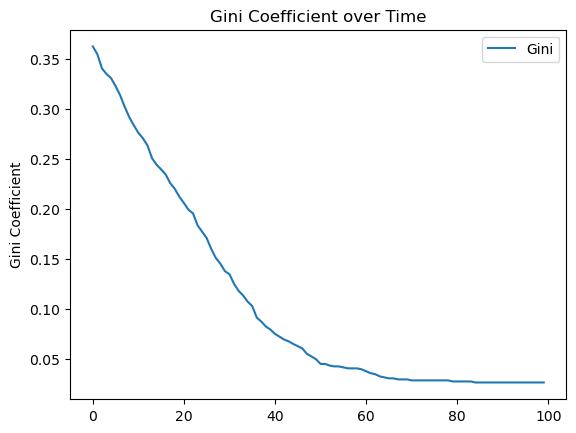

In [4]:
# Retrieve Gini coefficient data collected during the model run
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time using Seaborn
# Seaborn is a data visualization library in Python
g = sns.lineplot(data=gini)

# Set plot title and axis labels
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");
